In [1]:
pip install git+https://github.com/google-research/timesfm


  Cloning https://github.com/google-research/timesfm to /tmp/pip-req-build-qp45o9kr
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm /tmp/pip-req-build-qp45o9kr
  Resolved https://github.com/google-research/timesfm to commit dbe0fa528d58aa2946a88125a102a3417fe664b6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requireme

In [1]:
!pip install yfinance
!pip install utilsforecast


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

In [3]:
import timesfm
import gc
import numpy as np
import pandas as pd
from timesfm import patched_decoder
from timesfm import data_loader
import yfinance as yf

In [4]:
from tqdm import tqdm
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
# Loading TimesFM pretrained checkpoint
tfm = timesfm.TimesFm(
    context_len=64,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="gpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 4.55 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.42 seconds.
Jitting decoding.
Jitted decoding in 22.91 seconds.


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

# انتخاب نماد سهام (مثال: AAPL برای اپل)
ticker = 'AAPL'

# بارگذاری داده‌های بورسی روزانه
data = yf.download(ticker, start='2000-01-01', end='2023-01-01', interval='1d')
data = data.resample('1D').ffill()
data.reset_index(inplace=True)  # تبدیل شاخص به ستون

# تغییر نام ستون‌ها
data.rename(columns={'Date': 'date', 'Close': 'y'}, inplace=True)

# انتخاب ستون‌های مناسب
ts_cols = ["Open", "High", "Low", "y", "Volume"]

# محاسبه ویژگی‌های اضافی
data['MA_10'] = data['y'].rolling(window=10).mean()
data['MA_50'] = data['y'].rolling(window=50).mean()
data['RSI'] = 100 - (100 / (1 + data['y'].pct_change().rolling(window=14).apply(lambda x: (x[x > 0].mean() / -x[x < 0].mean()) if x[x < 0].mean() != 0 else np.inf)))



# انتخاب ستون‌های نهایی
final_cols = ["date", "Open", "High", "Low", "y", "Volume", "MA_10", "MA_50", "RSI"]
data = data[final_cols]

# ذخیره‌سازی داده‌ها در یک فایل CSV
data_path = 'stock_data.csv'
data.to_csv(data_path, index=False)

print(f"Number of records: {len(data)}")


[*********************100%%**********************]  1 of 1 completed


Number of records: 8398


In [7]:
freq = 'D'
context_len = 64
pred_len = 1
batch_size = 14

# Define train, validation, and test boundaries
train_boundary = int(len(data) * 0.7)
val_boundary = int(len(data) * 0.85)

In [8]:
train_boundary

5878

In [9]:
data

,date,Open,High,Low,y,Volume,MA_10,MA_50,RSI
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,535796800,NaN,NaN,NaN
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,512377600,NaN,NaN,NaN
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,778321600,NaN,NaN,NaN
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,767972800,NaN,NaN,NaN
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,460734400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8393,2022-12-26,130.919998,132.419998,129.639999,131.860001,63814900,132.880998,143.267599,47.157830
8394,2022-12-27,131.380005,131.410004,128.720001,130.029999,69007800,132.432999,143.089799,58.728618
8395,2022-12-28,129.669998,131.029999,125.870003,126.040001,85438400,131.585999,142.820599,56.107847
8396,2022-12-29,127.989998,130.479996,127.730003,129.610001,75703700,131.310000,142.715399,64.109504


In [10]:
ts_cols = [col for col in data.columns if col != "date"]


num_ts = len(ts_cols)
# Create TimeSeriesdata loader
dtl = data_loader.TimeSeriesdata(
      data_path=data_path,
      datetime_col="date",
      num_cov_cols=None,
      cat_cov_cols=None,
      ts_cols=ts_cols,
      train_range=[0, train_boundary],
      val_range=[train_boundary, val_boundary],
      test_range=[val_boundary, len(data)],
      hist_len=context_len,
      pred_len=pred_len,
      batch_size=num_ts,  # Change as per requirement
      freq=freq,
      normalize=True,
      epoch_len=None,
      holiday=False,
      permute=True,
  )
train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
test_batches = dtl.tf_dataset(mode="test", shift=pred_len)

In [11]:
for tbatch in tqdm(train_batches.as_numpy_iterator()):
    pass
print(tbatch[0].shape)

831it [00:04, 187.41it/s]

(6, 8, 64)


# MAE on the test split for the pretrained TimesFM model

In [12]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]

    actuals = batch[3]

    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]

    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

1260it [00:20, 60.91it/s]

MAE: 0.134437695145607


# Fine-tuning the model

In [13]:
import jax
from jax import numpy as jnp
from praxis import pax_fiddle
from praxis import py_utils
from praxis import pytypes
from praxis import base_model
from praxis import optimizers
from praxis import schedules
from praxis import base_hyperparams
from praxis import base_layer
from paxml import tasks_lib
from paxml import trainer_lib
from paxml import checkpoints
from paxml import learners
from paxml import partitioning
from paxml import checkpoint_types

In [14]:
NestedMap = py_utils.NestedMap
WeightInit = base_layer.WeightInit
WeightHParams = base_layer.WeightHParams
InstantiableParams = py_utils.InstantiableParams
JTensor = pytypes.JTensor
NpTensor = pytypes.NpTensor
WeightedScalars = pytypes.WeightedScalars
instantiate = base_hyperparams.instantiate
LayerTpl = pax_fiddle.Config[base_layer.BaseLayer]
AuxLossStruct = base_layer.AuxLossStruct

AUX_LOSS = base_layer.AUX_LOSS
template_field = base_layer.template_field

# Standard prng key names
PARAMS = base_layer.PARAMS
RANDOM = base_layer.RANDOM

key = jax.random.PRNGKey(seed=1234)

In [15]:
model = pax_fiddle.Config(
    patched_decoder.PatchedDecoderFinetuneModel,
    name='patched_decoder_finetune',
    core_layer_tpl=tfm.model_p,
)

In [16]:

@pax_fiddle.auto_config
def build_learner() -> learners.Learner:
  return pax_fiddle.Config(
      learners.Learner,
      name='learner',
      loss_name='avg_qloss',
      optimizer=optimizers.Adam(
          epsilon=1e-7,
          clip_threshold=1e2,
          learning_rate=1e-2,
          lr_schedule=pax_fiddle.Config(
              schedules.Cosine,
              initial_value=1e-3,
              final_value=1e-4,
              total_steps=40000,
          ),
          ema_decay=0.9999,
      ),
      # Linear probing i.e we hold the transformer layers fixed.
      bprop_variable_exclusion=['.*/stacked_transformer_layer/.*'],
  )

In [17]:

task_p = tasks_lib.SingleTask(
    name='ts-learn',
    model=model,
    train=tasks_lib.SingleTask.Train(
        learner=build_learner(),
    ),
)

In [18]:
task_p.model.ici_mesh_shape = [1, 1, 1]
task_p.model.mesh_axis_names = ['replica', 'data', 'mdl']

DEVICES = np.array(jax.devices()).reshape([1, 1, 1])
MESH = jax.sharding.Mesh(DEVICES, ['replica', 'data', 'mdl'])

num_devices = jax.local_device_count()
print(f'num_devices: {num_devices}')
print(f'device kind: {jax.local_devices()[0].device_kind}')

num_devices: 1
device kind: Tesla T4


In [19]:
jax_task = task_p
key, init_key = jax.random.split(key)

# To correctly prepare a batch of data for model initialization (now that shape
# inference is merged), we take one devices*batch_size tensor tuple of data,
# slice out just one batch, then run the prepare_input_batch function over it.


def process_train_batch(batch):
    past_ts = batch[0].reshape(len(batch[2]) * num_ts, -1)
    actual_ts = batch[3].reshape(len(batch[2]) * num_ts, -1)
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


def process_eval_batch(batch):
    past_ts = batch[0]
    actual_ts = batch[3]
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


jax_model_states, _ = trainer_lib.initialize_model_state(
    jax_task,
    init_key,
    process_train_batch(tbatch),
    checkpoint_type=checkpoint_types.CheckpointType.GDA,
)

In [20]:
jax_model_states.mdl_vars['params']['core_layer'] = tfm._train_state.mdl_vars['params']
jax_vars = jax_model_states.mdl_vars
gc.collect()

0

In [21]:
jax_task = task_p


def train_step(states, prng_key, inputs):
  return trainer_lib.train_step_single_learner(
      jax_task, states, prng_key, inputs
  )


def eval_step(states, prng_key, inputs):
  states = states.to_eval_state()
  return trainer_lib.eval_step_single_learner(
      jax_task, states, prng_key, inputs
  )

key, train_key, eval_key = jax.random.split(key, 3)
train_prng_seed = jax.random.split(train_key, num=jax.local_device_count())
eval_prng_seed = jax.random.split(eval_key, num=jax.local_device_count())

p_train_step = jax.pmap(train_step, axis_name='batch')
p_eval_step = jax.pmap(eval_step, axis_name='batch')

In [22]:
replicated_jax_states = trainer_lib.replicate_model_state(jax_model_states)
replicated_jax_vars = replicated_jax_states.mdl_vars

In [23]:
best_eval_loss = 1e7
step_count = 0
patience = 0
NUM_EPOCHS = 100
PATIENCE = 5
TRAIN_STEPS_PER_EVAL = 1000
CHECKPOINT_DIR='/content'

In [24]:
def reshape_batch_for_pmap(batch, num_devices):
  def _reshape(input_tensor):
    bsize = input_tensor.shape[0]
    residual_shape = list(input_tensor.shape[1:])
    nbsize = bsize // num_devices
    return jnp.reshape(input_tensor, [num_devices, nbsize] + residual_shape)

  return jax.tree.map(_reshape, batch)

In [25]:
for epoch in range(NUM_EPOCHS):
    print(f"__________________Epoch: {epoch}__________________", flush=True)
    train_its = train_batches.as_numpy_iterator()
    if patience >= PATIENCE:
        print("Early stopping.", flush=True)
        break
    for batch in tqdm(train_its):
        train_losses = []
        if patience >= PATIENCE:
            print("Early stopping.", flush=True)
            break
        tbatch = process_train_batch(batch)
        tbatch = reshape_batch_for_pmap(tbatch, num_devices)
        replicated_jax_states, step_fun_out = p_train_step(
            replicated_jax_states, train_prng_seed, tbatch
        )
        train_losses.append(step_fun_out.loss[0])
        if step_count % TRAIN_STEPS_PER_EVAL == 0:
            print(
                f"Train loss at step {step_count}: {np.mean(train_losses)}",
                flush=True,
            )
            train_losses = []
            print("Starting eval.", flush=True)
            val_its = val_batches.as_numpy_iterator()
            eval_losses = []
            for ev_batch in tqdm(val_its):
                ebatch = process_eval_batch(ev_batch)
                ebatch = reshape_batch_for_pmap(ebatch, num_devices)
                _, step_fun_out = p_eval_step(
                    replicated_jax_states, eval_prng_seed, ebatch
                )
                eval_losses.append(step_fun_out.loss[0])
            mean_loss = np.mean(eval_losses)
            print(f"Eval loss at step {step_count}: {mean_loss}", flush=True)
            if mean_loss < best_eval_loss or np.isnan(mean_loss):
                best_eval_loss = mean_loss
                print("Saving checkpoint.")
                jax_state_for_saving = py_utils.maybe_unreplicate_for_fully_replicated(
                    replicated_jax_states
                )
                checkpoints.save_checkpoint(
                    jax_state_for_saving, CHECKPOINT_DIR, overwrite=True
                )
                patience = 0
                del jax_state_for_saving
                gc.collect()
            else:
                patience += 1
                print(f"patience: {patience}")
        step_count += 1

__________________Epoch: 0__________________


0it [00:00, ?it/s]

Train loss at step 0: 0.7126297354698181
Starting eval.



0it [00:00, ?it/s]
1it [00:12, 12.02s/it]
9it [00:12,  1.02it/s]
17it [00:12,  2.32it/s]
25it [00:12,  4.10it/s]
35it [00:12,  7.13it/s]
45it [00:12, 11.09it/s]
55it [00:12, 16.16it/s]
65it [00:12, 22.35it/s]
75it [00:12, 29.63it/s]
85it [00:13, 37.68it/s]
95it [00:13, 46.10it/s]
105it [00:13, 54.25it/s]
114it [00:13, 60.87it/s]
123it [00:13, 66.94it/s]
133it [00:13, 72.88it/s]
143it [00:13, 77.57it/s]
153it [00:13, 81.12it/s]
163it [00:13, 83.78it/s]
173it [00:13, 85.71it/s]
183it [00:14, 87.10it/s]
193it [00:14, 87.84it/s]
203it [00:14, 88.01it/s]
212it [00:14, 88.39it/s]
222it [00:14, 88.89it/s]
231it [00:14, 88.52it/s]
240it [00:14, 88.74it/s]
250it [00:14, 90.40it/s]
260it [00:14, 90.27it/s]
270it [00:15, 90.34it/s]
280it [00:15, 90.10it/s]
290it [00:15, 89.82it/s]
299it [00:15, 89.74it/s]
309it [00:15, 89.83it/s]
318it [00:15, 89.78it/s]
328it [00:15, 90.09it/s]
338it [00:15, 90.21it/s]
348it [00:15, 90.29it/s]
358it [00:16, 90.34it/s]
368it [00:16, 90.14it/s]
378it [00:16, 89.8

Eval loss at step 0: 0.5548533797264099


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


831it [02:50,  4.86it/s]

__________________Epoch: 1__________________



168it [00:15, 11.26it/s]

Train loss at step 1000: 0.8121989965438843
Starting eval.



0it [00:00, ?it/s]
7it [00:00, 67.55it/s]
17it [00:00, 84.95it/s]
26it [00:00, 86.10it/s]
35it [00:00, 86.45it/s]
44it [00:00, 86.74it/s]
53it [00:00, 87.11it/s]
62it [00:00, 87.03it/s]
71it [00:00, 87.19it/s]
80it [00:00, 86.32it/s]
89it [00:01, 85.28it/s]
98it [00:01, 85.80it/s]
107it [00:01, 86.22it/s]
116it [00:01, 86.54it/s]
125it [00:01, 86.82it/s]
134it [00:01, 86.90it/s]
143it [00:01, 87.02it/s]
152it [00:01, 87.18it/s]
161it [00:01, 86.92it/s]
170it [00:01, 86.29it/s]
179it [00:02, 86.13it/s]
188it [00:02, 86.31it/s]
197it [00:02, 86.69it/s]
206it [00:02, 86.72it/s]
215it [00:02, 86.78it/s]
224it [00:02, 86.81it/s]
233it [00:02, 86.91it/s]
242it [00:02, 86.87it/s]
251it [00:02, 86.67it/s]
260it [00:03, 86.29it/s]
269it [00:03, 86.29it/s]
278it [00:03, 86.62it/s]
287it [00:03, 86.73it/s]
296it [00:03, 86.81it/s]
305it [00:03, 86.85it/s]
314it [00:03, 86.74it/s]
323it [00:03, 86.63it/s]
332it [00:03, 86.61it/s]
341it [00:03, 86.42it/s]
350it [00:04, 86.18it/s]
359it [00:04, 86.

Eval loss at step 1000: 0.5373640656471252


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


831it [01:55,  7.21it/s]

__________________Epoch: 2__________________



338it [00:30, 11.22it/s]

Train loss at step 2000: 0.7724195718765259
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 96.35it/s]
20it [00:00, 90.82it/s]
30it [00:00, 89.22it/s]
39it [00:00, 88.47it/s]
48it [00:00, 88.09it/s]
57it [00:00, 87.70it/s]
66it [00:00, 87.44it/s]
75it [00:00, 87.56it/s]
84it [00:00, 86.06it/s]
93it [00:01, 86.06it/s]
102it [00:01, 86.46it/s]
111it [00:01, 86.66it/s]
120it [00:01, 86.90it/s]
129it [00:01, 86.64it/s]
138it [00:01, 87.13it/s]
147it [00:01, 87.12it/s]
156it [00:01, 87.20it/s]
165it [00:01, 86.87it/s]
174it [00:01, 86.50it/s]
183it [00:02, 86.42it/s]
192it [00:02, 86.56it/s]
201it [00:02, 86.73it/s]
210it [00:02, 86.89it/s]
219it [00:02, 86.88it/s]
228it [00:02, 86.98it/s]
237it [00:02, 86.89it/s]
246it [00:02, 86.82it/s]
255it [00:02, 86.57it/s]
264it [00:03, 86.45it/s]
273it [00:03, 86.47it/s]
282it [00:03, 86.57it/s]
291it [00:03, 86.69it/s]
300it [00:03, 86.74it/s]
309it [00:03, 86.93it/s]
318it [00:03, 87.03it/s]
327it [00:03, 86.88it/s]
336it [00:03, 86.83it/s]
345it [00:03, 86.81it/s]
354it [00:04, 86.72it/s]
363it [00:04, 8

Eval loss at step 2000: 0.5303459167480469


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


831it [02:17,  6.07it/s]

__________________Epoch: 3__________________



506it [00:46, 11.23it/s]

Train loss at step 3000: 0.8213531374931335
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 97.07it/s]
20it [00:00, 91.15it/s]
30it [00:00, 89.57it/s]
39it [00:00, 88.73it/s]
48it [00:00, 88.33it/s]
57it [00:00, 87.87it/s]
66it [00:00, 87.63it/s]
75it [00:00, 87.70it/s]
84it [00:00, 86.52it/s]
93it [00:01, 86.51it/s]
102it [00:01, 86.71it/s]
111it [00:01, 87.34it/s]
120it [00:01, 87.25it/s]
129it [00:01, 87.21it/s]
138it [00:01, 87.44it/s]
147it [00:01, 87.32it/s]
156it [00:01, 87.35it/s]
165it [00:01, 86.92it/s]
174it [00:01, 86.52it/s]
183it [00:02, 86.65it/s]
192it [00:02, 86.85it/s]
201it [00:02, 86.96it/s]
210it [00:02, 87.10it/s]
219it [00:02, 87.06it/s]
228it [00:02, 87.22it/s]
237it [00:02, 87.22it/s]
246it [00:02, 86.99it/s]
255it [00:02, 86.70it/s]
264it [00:03, 86.75it/s]
273it [00:03, 86.67it/s]
282it [00:03, 86.70it/s]
291it [00:03, 86.88it/s]
300it [00:03, 86.89it/s]
309it [00:03, 87.15it/s]
318it [00:03, 87.45it/s]
327it [00:03, 86.84it/s]
336it [00:03, 87.17it/s]
345it [00:03, 86.87it/s]
354it [00:04, 86.97it/s]
363it [00:04, 8

Eval loss at step 3000: 0.5269849300384521


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


831it [02:16,  6.09it/s]

__________________Epoch: 4__________________



676it [01:02,  9.28it/s]

Train loss at step 4000: 0.40671440958976746
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 96.88it/s]
20it [00:00, 91.15it/s]
30it [00:00, 88.90it/s]
39it [00:00, 87.39it/s]
48it [00:00, 87.48it/s]
57it [00:00, 87.43it/s]
66it [00:00, 87.45it/s]
75it [00:00, 87.45it/s]
84it [00:00, 86.91it/s]
93it [00:01, 86.92it/s]
102it [00:01, 86.97it/s]
111it [00:01, 86.99it/s]
120it [00:01, 86.93it/s]
129it [00:01, 86.96it/s]
138it [00:01, 87.02it/s]
147it [00:01, 87.07it/s]
156it [00:01, 87.22it/s]
165it [00:01, 87.11it/s]
174it [00:01, 87.06it/s]
183it [00:02, 87.13it/s]
192it [00:02, 87.04it/s]
201it [00:02, 86.93it/s]
210it [00:02, 86.71it/s]
219it [00:02, 86.81it/s]
228it [00:02, 86.93it/s]
237it [00:02, 86.98it/s]
246it [00:02, 87.10it/s]
255it [00:02, 87.05it/s]
264it [00:03, 87.12it/s]
273it [00:03, 87.09it/s]
282it [00:03, 86.07it/s]
292it [00:03, 87.32it/s]
301it [00:03, 87.33it/s]
310it [00:03, 87.23it/s]
319it [00:03, 86.88it/s]
328it [00:03, 87.01it/s]
337it [00:03, 87.21it/s]
346it [00:03, 87.09it/s]
355it [00:04, 87.31it/s]
364it [00:04, 8

Eval loss at step 4000: 0.5251399278640747


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


831it [02:10,  6.38it/s]

__________________Epoch: 5__________________



831it [01:16, 10.81it/s]

__________________Epoch: 6__________________



14it [00:01, 11.35it/s]

Train loss at step 5000: 0.6395962238311768
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 94.58it/s]
20it [00:00, 90.89it/s]
30it [00:00, 89.48it/s]
39it [00:00, 88.91it/s]
48it [00:00, 88.43it/s]
57it [00:00, 88.28it/s]
66it [00:00, 88.03it/s]
75it [00:00, 87.84it/s]
84it [00:00, 86.74it/s]
93it [00:01, 86.23it/s]
102it [00:01, 86.99it/s]
111it [00:01, 87.17it/s]
120it [00:01, 87.14it/s]
129it [00:01, 87.30it/s]
138it [00:01, 87.39it/s]
147it [00:01, 87.53it/s]
156it [00:01, 87.90it/s]
165it [00:01, 87.56it/s]
174it [00:01, 87.17it/s]
183it [00:02, 87.02it/s]
192it [00:02, 87.22it/s]
201it [00:02, 87.20it/s]
210it [00:02, 87.42it/s]
219it [00:02, 87.44it/s]
228it [00:02, 87.45it/s]
237it [00:02, 87.52it/s]
246it [00:02, 87.81it/s]
255it [00:02, 87.59it/s]
264it [00:03, 87.30it/s]
273it [00:03, 87.14it/s]
282it [00:03, 87.34it/s]
291it [00:03, 87.23it/s]
300it [00:03, 87.43it/s]
309it [00:03, 87.68it/s]
318it [00:03, 87.58it/s]
327it [00:03, 87.58it/s]
336it [00:03, 87.49it/s]
345it [00:03, 87.29it/s]
354it [00:04, 87.06it/s]
363it [00:04, 8

Eval loss at step 5000: 0.5311567187309265


17it [00:16,  1.89s/it]

patience: 1


831it [01:30,  9.15it/s]

__________________Epoch: 7__________________



182it [00:16, 10.47it/s]

Train loss at step 6000: 0.5288375616073608
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 96.48it/s]
20it [00:00, 90.63it/s]
30it [00:00, 88.97it/s]
39it [00:00, 88.46it/s]
48it [00:00, 87.98it/s]
57it [00:00, 87.74it/s]
66it [00:00, 87.34it/s]
75it [00:00, 87.35it/s]
84it [00:00, 86.28it/s]
93it [00:01, 86.17it/s]
102it [00:01, 86.39it/s]
111it [00:01, 86.55it/s]
120it [00:01, 86.72it/s]
129it [00:01, 86.93it/s]
138it [00:01, 86.98it/s]
147it [00:01, 86.84it/s]
156it [00:01, 86.81it/s]
165it [00:01, 86.30it/s]
174it [00:01, 86.23it/s]
183it [00:02, 86.35it/s]
192it [00:02, 86.39it/s]
201it [00:02, 86.59it/s]
210it [00:02, 86.76it/s]
219it [00:02, 86.85it/s]
228it [00:02, 86.98it/s]
237it [00:02, 87.02it/s]
246it [00:02, 86.91it/s]
255it [00:02, 86.58it/s]
264it [00:03, 86.52it/s]
273it [00:03, 86.46it/s]
282it [00:03, 86.45it/s]
291it [00:03, 86.60it/s]
300it [00:03, 86.70it/s]
309it [00:03, 86.82it/s]
318it [00:03, 86.99it/s]
327it [00:03, 86.84it/s]
336it [00:03, 86.75it/s]
345it [00:03, 86.67it/s]
354it [00:04, 86.76it/s]
363it [00:04, 8

Eval loss at step 6000: 0.5242108106613159


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


831it [02:15,  6.14it/s]

__________________Epoch: 8__________________



352it [00:31, 11.31it/s]

Train loss at step 7000: 0.6913942694664001
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 96.51it/s]
20it [00:00, 90.86it/s]
30it [00:00, 89.33it/s]
39it [00:00, 88.65it/s]
48it [00:00, 88.24it/s]
57it [00:00, 88.00it/s]
66it [00:00, 87.83it/s]
75it [00:00, 87.74it/s]
84it [00:00, 86.35it/s]
93it [00:01, 86.28it/s]
102it [00:01, 86.77it/s]
111it [00:01, 87.37it/s]
120it [00:01, 87.40it/s]
129it [00:01, 87.39it/s]
138it [00:01, 87.57it/s]
147it [00:01, 87.82it/s]
156it [00:01, 87.79it/s]
165it [00:01, 87.53it/s]
174it [00:01, 87.03it/s]
183it [00:02, 86.81it/s]
192it [00:02, 86.98it/s]
201it [00:02, 86.90it/s]
210it [00:02, 87.11it/s]
219it [00:02, 87.09it/s]
228it [00:02, 87.23it/s]
237it [00:02, 87.19it/s]
246it [00:02, 86.97it/s]
255it [00:02, 86.92it/s]
264it [00:03, 86.58it/s]
273it [00:03, 86.76it/s]
282it [00:03, 86.84it/s]
291it [00:03, 86.87it/s]
300it [00:03, 86.96it/s]
309it [00:03, 87.12it/s]
318it [00:03, 87.57it/s]
327it [00:03, 87.50it/s]
336it [00:03, 87.11it/s]
345it [00:03, 86.94it/s]
354it [00:04, 86.84it/s]
363it [00:04, 8

Eval loss at step 7000: 0.5250508785247803


355it [00:46,  1.82s/it]

patience: 1


831it [01:30,  9.16it/s]

__________________Epoch: 9__________________



520it [00:47, 10.48it/s]

Train loss at step 8000: 0.42523112893104553
Starting eval.



0it [00:00, ?it/s]
9it [00:00, 88.94it/s]
18it [00:00, 84.45it/s]
27it [00:00, 85.76it/s]
36it [00:00, 86.59it/s]
45it [00:00, 86.80it/s]
54it [00:00, 87.06it/s]
63it [00:00, 87.13it/s]
72it [00:00, 85.93it/s]
81it [00:00, 84.42it/s]
91it [00:01, 86.52it/s]
100it [00:01, 86.49it/s]
109it [00:01, 86.73it/s]
118it [00:01, 86.30it/s]
127it [00:01, 87.17it/s]
136it [00:01, 87.27it/s]
145it [00:01, 87.40it/s]
154it [00:01, 87.47it/s]
163it [00:01, 87.15it/s]
172it [00:01, 86.94it/s]
181it [00:02, 86.71it/s]
190it [00:02, 86.81it/s]
199it [00:02, 86.84it/s]
208it [00:02, 86.72it/s]
217it [00:02, 87.21it/s]
226it [00:02, 87.24it/s]
235it [00:02, 87.29it/s]
244it [00:02, 87.12it/s]
253it [00:02, 87.10it/s]
262it [00:03, 86.81it/s]
271it [00:03, 86.67it/s]
280it [00:03, 86.72it/s]
289it [00:03, 86.85it/s]
298it [00:03, 86.97it/s]
307it [00:03, 86.95it/s]
316it [00:03, 87.08it/s]
325it [00:03, 87.12it/s]
334it [00:03, 86.86it/s]
343it [00:03, 86.93it/s]
352it [00:04, 86.65it/s]
361it [00:04, 86

Eval loss at step 8000: 0.5232862830162048


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


831it [02:17,  6.07it/s]

__________________Epoch: 10__________________



690it [01:03, 11.38it/s]

Train loss at step 9000: 0.24202725291252136
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 94.39it/s]
20it [00:00, 90.06it/s]
30it [00:00, 88.80it/s]
39it [00:00, 88.42it/s]
48it [00:00, 87.85it/s]
57it [00:00, 87.83it/s]
66it [00:00, 87.71it/s]
75it [00:00, 87.67it/s]
84it [00:00, 86.06it/s]
93it [00:01, 85.87it/s]
102it [00:01, 86.43it/s]
111it [00:01, 86.45it/s]
120it [00:01, 86.67it/s]
129it [00:01, 86.91it/s]
138it [00:01, 87.06it/s]
147it [00:01, 87.04it/s]
156it [00:01, 87.17it/s]
165it [00:01, 86.89it/s]
174it [00:01, 86.67it/s]
183it [00:02, 86.50it/s]
192it [00:02, 86.73it/s]
201it [00:02, 86.82it/s]
210it [00:02, 86.95it/s]
219it [00:02, 87.00it/s]
228it [00:02, 86.97it/s]
237it [00:02, 87.15it/s]
246it [00:02, 86.93it/s]
255it [00:02, 86.68it/s]
264it [00:03, 86.52it/s]
273it [00:03, 86.54it/s]
282it [00:03, 86.83it/s]
291it [00:03, 86.91it/s]
300it [00:03, 86.87it/s]
309it [00:03, 87.09it/s]
318it [00:03, 87.12it/s]
327it [00:03, 87.01it/s]
336it [00:03, 86.98it/s]
345it [00:03, 86.91it/s]
354it [00:04, 86.76it/s]
363it [00:04, 8

Eval loss at step 9000: 0.5248335003852844


693it [01:18,  1.82s/it]

patience: 1


831it [01:31,  9.12it/s]

__________________Epoch: 11__________________



831it [01:16, 10.92it/s]

__________________Epoch: 12__________________



28it [00:02, 11.08it/s]

Train loss at step 10000: 1.7546297311782837
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 96.45it/s]
20it [00:00, 91.09it/s]
30it [00:00, 89.76it/s]
39it [00:00, 89.23it/s]
48it [00:00, 88.66it/s]
57it [00:00, 88.39it/s]
66it [00:00, 88.10it/s]
75it [00:00, 87.81it/s]
84it [00:00, 86.53it/s]
93it [00:01, 86.40it/s]
102it [00:01, 86.77it/s]
111it [00:01, 87.01it/s]
120it [00:01, 87.02it/s]
129it [00:01, 87.14it/s]
138it [00:01, 87.34it/s]
147it [00:01, 87.39it/s]
156it [00:01, 87.33it/s]
165it [00:01, 87.05it/s]
174it [00:01, 86.73it/s]
183it [00:02, 87.02it/s]
192it [00:02, 87.07it/s]
201it [00:02, 86.94it/s]
210it [00:02, 87.16it/s]
219it [00:02, 87.17it/s]
228it [00:02, 87.35it/s]
237it [00:02, 87.41it/s]
246it [00:02, 87.10it/s]
255it [00:02, 87.28it/s]
264it [00:03, 87.10it/s]
273it [00:03, 87.16it/s]
282it [00:03, 87.08it/s]
291it [00:03, 87.06it/s]
300it [00:03, 86.87it/s]
309it [00:03, 86.74it/s]
318it [00:03, 87.12it/s]
327it [00:03, 87.11it/s]
336it [00:03, 86.95it/s]
345it [00:03, 86.91it/s]
354it [00:04, 86.89it/s]
363it [00:04, 8

Eval loss at step 10000: 0.5292080044746399


31it [00:17,  1.83s/it]

patience: 2


831it [01:31,  9.08it/s]

__________________Epoch: 13__________________



196it [00:17, 11.21it/s]

Train loss at step 11000: 0.5764214992523193
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 95.21it/s]
20it [00:00, 90.71it/s]
30it [00:00, 89.28it/s]
39it [00:00, 88.57it/s]
48it [00:00, 88.23it/s]
57it [00:00, 87.82it/s]
66it [00:00, 87.76it/s]
75it [00:00, 87.60it/s]
84it [00:00, 86.57it/s]
93it [00:01, 86.52it/s]
102it [00:01, 86.62it/s]
111it [00:01, 86.86it/s]
120it [00:01, 87.07it/s]
129it [00:01, 87.09it/s]
138it [00:01, 87.09it/s]
147it [00:01, 87.22it/s]
156it [00:01, 87.20it/s]
165it [00:01, 86.77it/s]
174it [00:01, 86.15it/s]
183it [00:02, 86.64it/s]
192it [00:02, 86.75it/s]
201it [00:02, 86.95it/s]
210it [00:02, 86.91it/s]
219it [00:02, 87.16it/s]
228it [00:02, 87.20it/s]
237it [00:02, 87.10it/s]
246it [00:02, 87.18it/s]
255it [00:02, 87.01it/s]
264it [00:03, 86.70it/s]
273it [00:03, 86.73it/s]
282it [00:03, 86.87it/s]
291it [00:03, 87.03it/s]
300it [00:03, 87.20it/s]
309it [00:03, 87.15it/s]
318it [00:03, 86.99it/s]
327it [00:03, 87.10it/s]
336it [00:03, 87.04it/s]
345it [00:03, 87.08it/s]
354it [00:04, 86.94it/s]
363it [00:04, 8

Eval loss at step 11000: 0.5362434387207031


200it [00:33,  1.64s/it]

patience: 3


831it [01:31,  9.10it/s]

__________________Epoch: 14__________________



366it [00:33, 11.03it/s]

Train loss at step 12000: 0.7369577288627625
Starting eval.



0it [00:00, ?it/s]
8it [00:00, 70.55it/s]
18it [00:00, 84.87it/s]
27it [00:00, 85.90it/s]
36it [00:00, 86.34it/s]
45it [00:00, 86.65it/s]
54it [00:00, 86.96it/s]
63it [00:00, 87.04it/s]
72it [00:00, 87.18it/s]
81it [00:00, 86.46it/s]
90it [00:01, 86.18it/s]
99it [00:01, 86.26it/s]
108it [00:01, 86.61it/s]
117it [00:01, 86.75it/s]
126it [00:01, 87.01it/s]
135it [00:01, 87.27it/s]
144it [00:01, 87.15it/s]
153it [00:01, 87.12it/s]
162it [00:01, 87.02it/s]
171it [00:01, 86.78it/s]
180it [00:02, 86.66it/s]
189it [00:02, 86.75it/s]
198it [00:02, 86.70it/s]
207it [00:02, 87.02it/s]
216it [00:02, 87.09it/s]
225it [00:02, 87.08it/s]
234it [00:02, 86.96it/s]
243it [00:02, 87.22it/s]
252it [00:02, 86.98it/s]
261it [00:03, 86.83it/s]
270it [00:03, 86.88it/s]
279it [00:03, 86.85it/s]
288it [00:03, 86.86it/s]
297it [00:03, 87.03it/s]
306it [00:03, 87.03it/s]
315it [00:03, 87.12it/s]
324it [00:03, 87.44it/s]
333it [00:03, 87.24it/s]
342it [00:03, 87.07it/s]
351it [00:04, 86.93it/s]
360it [00:04, 86.

Eval loss at step 12000: 0.528896152973175


369it [00:48,  1.83s/it]

patience: 4


831it [01:31,  9.11it/s]

__________________Epoch: 15__________________



534it [00:49, 10.43it/s]

Train loss at step 13000: 0.9633370637893677
Starting eval.



0it [00:00, ?it/s]
9it [00:00, 89.66it/s]
18it [00:00, 88.73it/s]
27it [00:00, 88.78it/s]
36it [00:00, 88.52it/s]
45it [00:00, 88.18it/s]
54it [00:00, 88.07it/s]
63it [00:00, 88.29it/s]
72it [00:00, 88.06it/s]
81it [00:00, 86.95it/s]
90it [00:01, 86.40it/s]
99it [00:01, 87.02it/s]
108it [00:01, 87.44it/s]
117it [00:01, 87.73it/s]
126it [00:01, 87.94it/s]
135it [00:01, 88.16it/s]
144it [00:01, 88.04it/s]
153it [00:01, 87.97it/s]
162it [00:01, 87.72it/s]
171it [00:01, 86.85it/s]
180it [00:02, 86.87it/s]
189it [00:02, 87.10it/s]
198it [00:02, 87.19it/s]
207it [00:02, 87.31it/s]
216it [00:02, 87.74it/s]
225it [00:02, 87.82it/s]
234it [00:02, 87.85it/s]
243it [00:02, 87.85it/s]
252it [00:02, 88.06it/s]
261it [00:02, 87.68it/s]
270it [00:03, 87.51it/s]
279it [00:03, 87.41it/s]
288it [00:03, 87.37it/s]
297it [00:03, 87.35it/s]
306it [00:03, 87.49it/s]
315it [00:03, 87.55it/s]
324it [00:03, 87.88it/s]
333it [00:03, 87.72it/s]
342it [00:03, 87.60it/s]
351it [00:04, 87.41it/s]
360it [00:04, 87.

Eval loss at step 13000: 0.5294495820999146


536it [01:04,  2.30s/it]

patience: 5
Early stopping.


536it [01:04,  8.36it/s]

__________________Epoch: 16__________________
Early stopping.


In [26]:
train_state = checkpoints.restore_checkpoint(jax_model_states, CHECKPOINT_DIR)
print(train_state.step)
tfm._train_state.mdl_vars['params'] = train_state.mdl_vars['params']['core_layer']
tfm.jit_decode()

ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


8001
Jitting decoding.
Jitted decoding in 19.72 seconds.


In [27]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

1260it [00:21, 58.60it/s]


MAE: 0.12712757289409637


In [28]:

# Download stock data from Yahoo Finance
ticker = 'AAPL'  # Example: Apple Inc.
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
data = data.resample('1D').ffill()

df = data[['Close']].reset_index()
df.columns = ['date', 'close']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,close
date,
2023-01-03,125.070000
2023-01-04,126.360001
2023-01-05,125.019997
2023-01-06,129.619995
2023-01-07,129.619995
...,...
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [29]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [30]:
context_len=64
input_patch_len=32
horizon_len=1
batch_size=1

In [31]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [32]:

      input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)
      metrics = defaultdict(list)
      results = []

      # Process in smaller sub-batches
      for i, example in enumerate(input_data()):
          raw_forecast, _ = tfm.forecast(
              inputs=example["inputs"], freq=[0] * len(example["inputs"])
          )

          for j in range(len(example["inputs"])):
              result = {
                  'input_index': j,
                  'train_start_date': str(example["dates"][j][0]),
                  'train_end_date': str(example["dates"][j][-2]),
                  'predict_date': str(example["dates"][j][-1]),
                  'raw_forecast': raw_forecast[j][0],
                  'y_actual': example["outputs"][j][0],
                  'batch_size': batch_size,
                  'context_len': context_len,
                  'input_patch_len': input_patch_len
              }
              results.append(result)

In [33]:
 results_df = pd.DataFrame(results)
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,batch_size,context_len,input_patch_len
0,0,2023-01-03 00:00:00,2023-03-07 00:00:00,2023-03-08 00:00:00,152.009781,152.869995,1,64,32
1,0,2023-01-04 00:00:00,2023-03-08 00:00:00,2023-03-09 00:00:00,152.313812,150.589996,1,64,32
2,0,2023-01-05 00:00:00,2023-03-09 00:00:00,2023-03-10 00:00:00,150.403091,148.500000,1,64,32
3,0,2023-01-06 00:00:00,2023-03-10 00:00:00,2023-03-11 00:00:00,148.065720,148.500000,1,64,32
4,0,2023-01-07 00:00:00,2023-03-11 00:00:00,2023-03-12 00:00:00,147.759995,148.500000,1,64,32
...,...,...,...,...,...,...,...,...,...
291,0,2023-10-21 00:00:00,2023-12-23 00:00:00,2023-12-24 00:00:00,193.308304,193.600006,1,64,32
292,0,2023-10-22 00:00:00,2023-12-24 00:00:00,2023-12-25 00:00:00,193.643326,193.600006,1,64,32
293,0,2023-10-23 00:00:00,2023-12-25 00:00:00,2023-12-26 00:00:00,192.934586,193.050003,1,64,32
294,0,2023-10-24 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,192.494461,193.149994,1,64,32


In [34]:
results_df.to_pickle('finetune_2000_result.pkl')

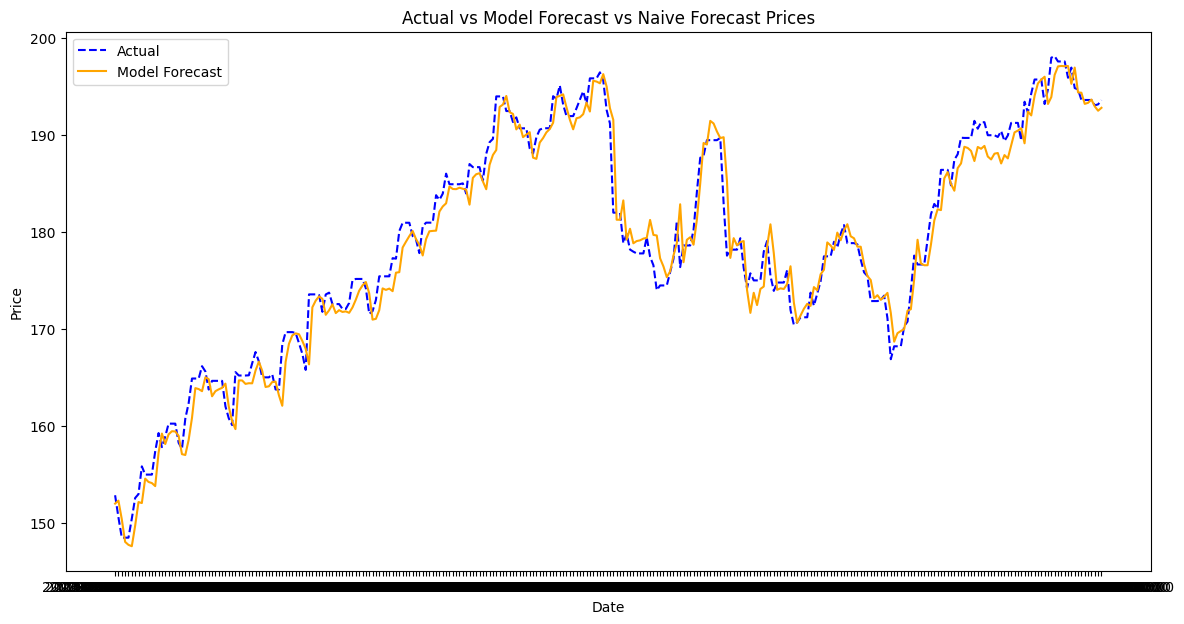

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['y_actual'], label='Actual', color='blue', linestyle='--')
plt.plot(results_df['predict_date'], results_df['raw_forecast'], label='Model Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Model Forecast vs Naive Forecast Prices')
plt.legend()
plt.show()

In [36]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, results_by_context_len):
    # فیلتر کردن داده‌ها برای context_len مشخص شده
    context_results_df =results_by_context_len

    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # ساخت دیکشنری از نتایج محاسبه شده
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# فراخوانی تابع برای یک context_len خاص
context_len = 64  # برای مثال
final_result_df = calculate_results_for_context_len(context_len, results_df)
print(final_result_df)


   context_len       mse  accuracy  direction_accuracy  \
0           64  4.563297  0.352542            0.477966   

   actual_direction_accuracy  direction_profit   profit  
0                   0.586441         14.159147  0.04407  
